In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('agents')

100%|██████████| 320/320 [00:37<00:00,  8.43it/s]


In [9]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [10]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      'kl_penalty_coeff': [3, 0.0],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [12]:
metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
code_level_opts = {'kl_penalty': [True, False]}
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot max rewards

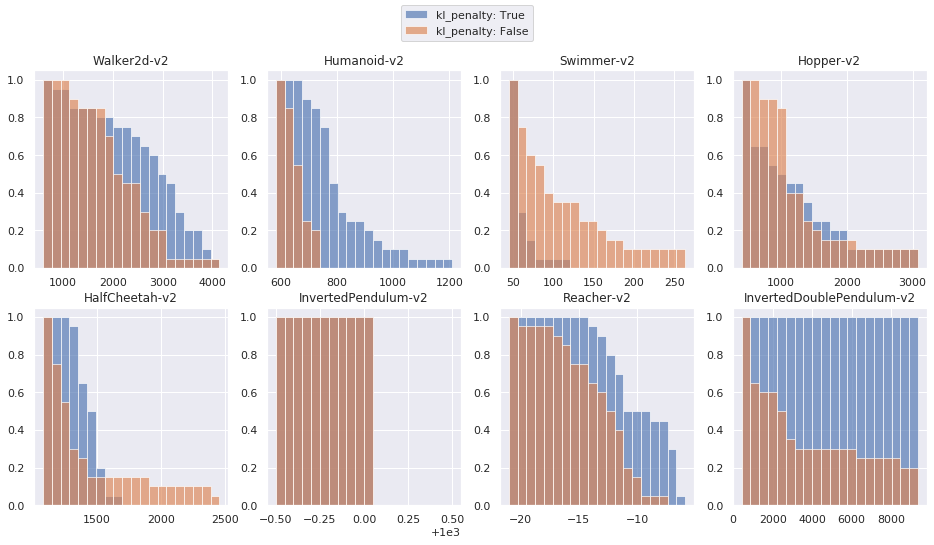

In [38]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

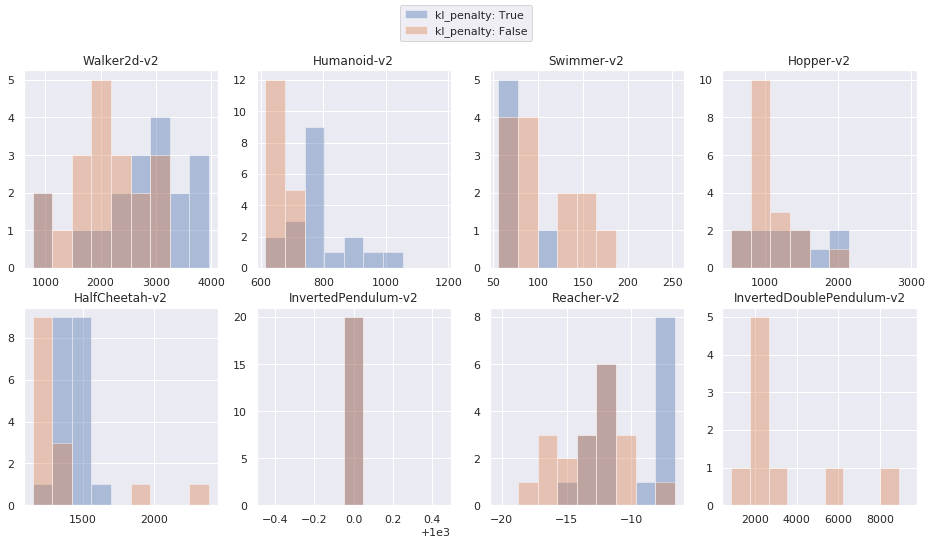

In [37]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), 10)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


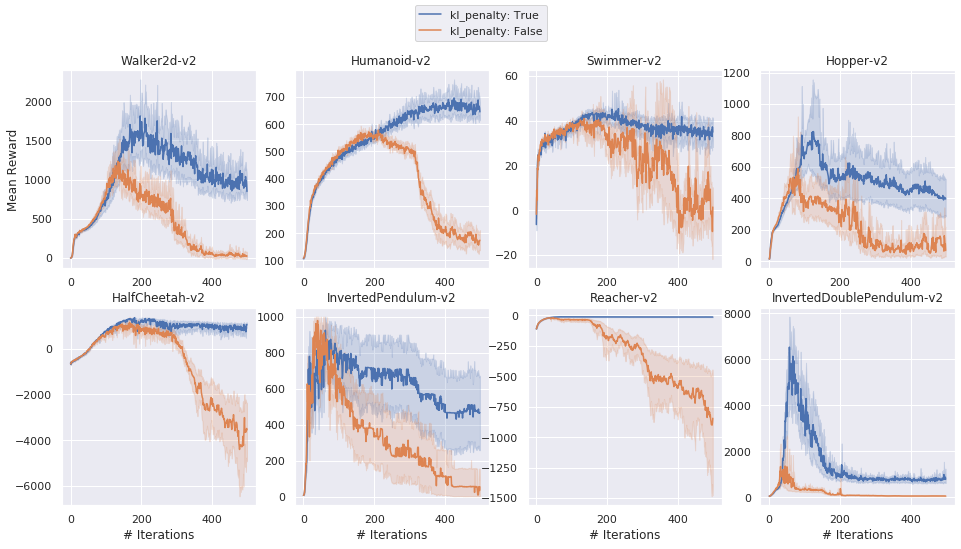

In [40]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

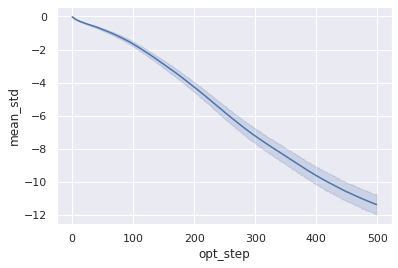

In [9]:
sns.lineplot(x=opt['opt_step'], y=np.log(opt['mean_std']))
plt.show()

# Aggregate performance (max over learning rates, avg over trials)

In [ ]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [55]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped['kl_penalty'] = (grouped['kl_penalty_coeff'] == 3)
ks = ['game', 'kl_penalty']
grouped = grouped.set_index(ks).drop(columns=['kl_penalty_coeff'])
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

mean_max_reward       stddev  \
game                      kl_penalty                                 
HalfCheetah-v2            False           1571.373204   630.971737   
                          True            1925.941911   824.541277   
Hopper-v2                 False           1176.497721   554.424173   
                          True             626.136104   479.734116   
Humanoid-v2               False            649.998689    54.267165   
                          True             801.820932   111.295774   
InvertedDoublePendulum-v2 False           4040.986048  3833.354554   
                          True            8921.543041  1222.881657   
Reacher-v2                False            -14.090069     2.653659   
                          True              -8.708299     2.070817   
Swimmer-v2                False            102.109784    63.020644   
                          True              61.179073    21.300581   
Walker2d-v2               False           2185.483800   721.530781   
                          True            2437.630293   812.520946   

                                      max_max_reward  min_max_reward  \
game                      kl_penalty                                   
HalfCheetah-v2            False          3702.089717     1021.847924   
                          True           3702.089717     1021.847924   
Hopper-v2                 False          2532.535424      371.253113   
                          True           2532.535424      371.253113   
Humanoid-v2               False          1046.722278      569.022818   
                          True           1046.722278      569.022818   
InvertedDoublePendulum-v2 False          9345.485562      439.959569   
                          True           9345.485562      439.959569   
Reacher-v2                False            -6.308010      -19.947526   
                          True             -6.308010      -19.947526   
Swimmer-v2                False           224.157074       40.545378   
                          True            224.157074       40.545378   
Walker2d-v2               False          3916.051726      711.857497   
                          True           3916.051726      711.857497   

                                      normalized_score  normalized_stddev  
game                      kl_penalty                                       
HalfCheetah-v2            False               0.205028           0.235416  
                          True                0.337318           0.307637  
Hopper-v2                 False               0.372577           0.256526  
                          True                0.117931           0.221967  
Humanoid-v2               False               0.169512           0.113601  
                          True                0.487332           0.232983  
InvertedDoublePendulum-v2 False               0.404359           0.430447  
                          True                0.952396           0.137317  
Reacher-v2                False               0.429448           0.194557  
                          True                0.824019           0.151825  
Swimmer-v2                False               0.335297           0.343228  
                          True                0.112377           0.116009  
Walker2d-v2               False               0.459905           0.225183  
                          True                0.538598           0.253580

In [68]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
tmp['kl_penalty'] = (tmp['kl_penalty_coeff'] == 3)
normalized_score = tmp[['game', 'kl_penalty', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


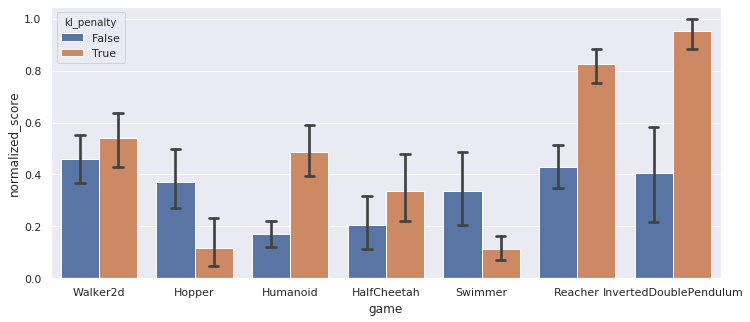

In [69]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="kl_penalty", data=normalized_score.dropna().reset_index(), capsize=.1)

In [71]:
normalized_score.groupby('kl_penalty').mean()

,normalized_score
kl_penalty,
False,0.339447
True,0.481424


In [73]:
normalized_score.groupby('kl_penalty').std()

,normalized_score
kl_penalty,
False,0.287479
True,0.366501
